In [1]:
import os
from os import listdir

import keras
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Keras
from keras import regularizers
from keras.models import model_from_json

import wave
import pyaudio

import PIL
from PIL import Image
import cv2

Using TensorFlow backend.


In [2]:
from keras.models import model_from_json
json_file = open('saved_models/model_face_final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_face = model_from_json(loaded_model_json)
# load weights into new model
model_face.load_weights("saved_models/model_face_final_weights.h5")

In [3]:
from keras.models import model_from_json
json_file = open('saved_models/model_audio_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_audio = model_from_json(loaded_model_json)
# load weights into new model
model_audio.load_weights("saved_models/model_audio_augweights.h5")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
EMOTION_DICT = {0:"ANGRY", 1:"DISGUST", 2:"FEAR", 3:"HAPPY", 6:"NEUTRAL", 4:"SAD", 5:"SURPRISE"}
# model_top = load_model('C:\\Users\\AAKASH\\Desktop\\minor_project\\saved_models\\model_weights.h5')

In [5]:
# function to plot bar graph

def plot_bar_graph(probs):
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    probs = probs * 100
    index = np.arange(len(labels))
    plt.bar(index, probs)
    plt.xlabel('Emotions')
    plt.ylabel('Probability (in %)')
    plt.xticks(index, labels, rotation=30)
    plt.title('Predicted probabilities vs emotions')
    plt.show()

In [6]:
def predict_audio():
    file = 'images/file.wav'
    X, sample_rate = librosa.load(file, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = np.array(mfccs)
    if(feature.size != 259):
        if(feature.size < 259):
            temp = np.full((259 - feature.size,), np.mean(feature))
            feature = np.concatenate((feature, temp), axis = 0)
        else:
            feature = feature[: 259 - feature.size]
    feature = feature.reshape((1, feature.shape[0], 1))
    preds = model_audio.predict(feature)
    return preds[0]

In [7]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 

def predict_face():
    #converting image to gray scale and save it
    images = ['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg']
    for image in images:
        path = os.path.join('images', image)
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(path, gray)

        #detect face in image, crop it then resize it then save it
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            face_clip = img[y:y+h, x:x+w]
            cv2.imwrite(path, cv2.resize(face_clip, (48, 48)))
            
    cropped_img = []
    for image in images:
        img = Image.open(os.path.join('images', image))
        if(img.size[0] == 48 and img.size[1] == 48):
            cropped_img.append(image)
            
    if(len(cropped_img) == 0):
        return 'Try Again'
    
    #read the processed image then make prediction and display the result
    pred_images = []
    for image in cropped_img:
        path = os.path.join('images', image)
        read_image = cv2.imread(path)
        read_image = np.array(Image.open(path).convert('L'), dtype="int32")
        read_image = read_image.astype('float32')
        read_image = read_image / 255.0
        read_image = (read_image - 0.5) * 2
        read_image = read_image.reshape((48, 48, 1))
        read_image_final = read_image.reshape(1, read_image.shape[0], read_image.shape[1], read_image.shape[2])
        top_pred = model_face.predict(read_image_final)
        pred_images.append(top_pred[0])
    
    return np.array(np.mean(pred_images, axis = 0))

In [8]:
def predict():
    preds1 = predict_face()
    if(preds1 == 'Try Again'):
        preds1 = np.zeros(7)
    preds2 = predict_audio()
    preds = 0.67*preds1 + 0.33*preds2
    return EMOTION_DICT[np.argmax(preds)], preds

In [9]:
# FORMAT = pyaudio.paInt16
# CHANNELS = 2
# RATE = 44100
# CHUNK = 1024
# RECORD_SECONDS = 4
# WAVE_OUTPUT_FILENAME = "images/file.wav"
    
def capture_audio():

    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    CHUNK = 1024
    RECORD_SECONDS = 4
    WAVE_OUTPUT_FILENAME = "images/file.wav"
    audio = pyaudio.PyAudio()
    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)
    print ("recording...")
    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print ("finished recording")


    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()

    waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()

# predict('file.wav')


In [10]:
import cv2
import time

# vidcap = cv2.VideoCapture(0)

def capture_images():    
    def getFrame():
    #     vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            cv2.imwrite("images/image"+str(count)+".jpg", image)     # save frame as JPG file
        return hasFrames
    sec = 0
    frameRate = 0.5 #//it will capture image in each 0.5 second
    count=1
    success = getFrame()
    cont = True
    while success and cont:
        count = count + 1
    #     sec = sec + frameRate
    #     sec = round(sec, 2)
        success = getFrame()
        time.sleep(1/2)
        if count == 5:
            cont = False

    # Close the window / Release webcam 
    vidcap.release()   
    # De-allocate any associated memory usage  
    cv2.destroyAllWindows() 

In [11]:
# capture_images()

recording...
finished recording
4


C:\Users\AAKASH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Predicted emotion:  HAPPY


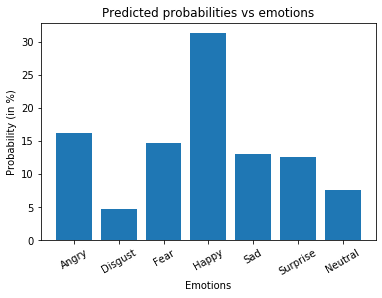

In [13]:
import threading
import datetime

vidcap = cv2.VideoCapture(0)

t1 = threading.Thread(target = capture_images, name = 'thread1')
t2 = threading.Thread(target = capture_audio, name = 'thread2')
a = datetime.datetime.now()
t1.start()
t2.start()
t1.join()
t2.join()
b = datetime.datetime.now()
print((b-a).seconds)

x, y = predict()
print('Predicted emotion: ', x)
plot_bar_graph(y)
# predict('face_test.jpg', 'audio_test.wav')